## Multi-task Learning for Predicting House Prices and House Category

## 1. Data Exploration

### 1.1 Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger, CSVLogger
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score, Accuracy, AUROC, F1Score

import optuna

In [2]:
np.random.seed(123)

### 1.2 Read the dataset

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 1.3 Analyze the Target Variable (Sales Price)

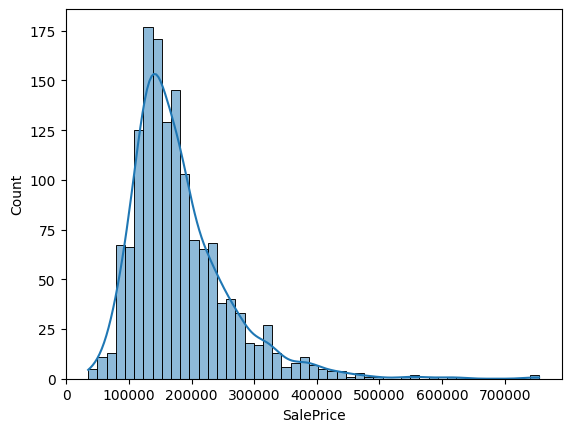

In [5]:
sns.histplot(df['SalePrice'], kde=True);

### 1.4 Analyze Numerical Variables

In [6]:
df_numeric = df.select_dtypes(include = ['float64', 'int64'])

1.4.1 Plot distribution of each variable

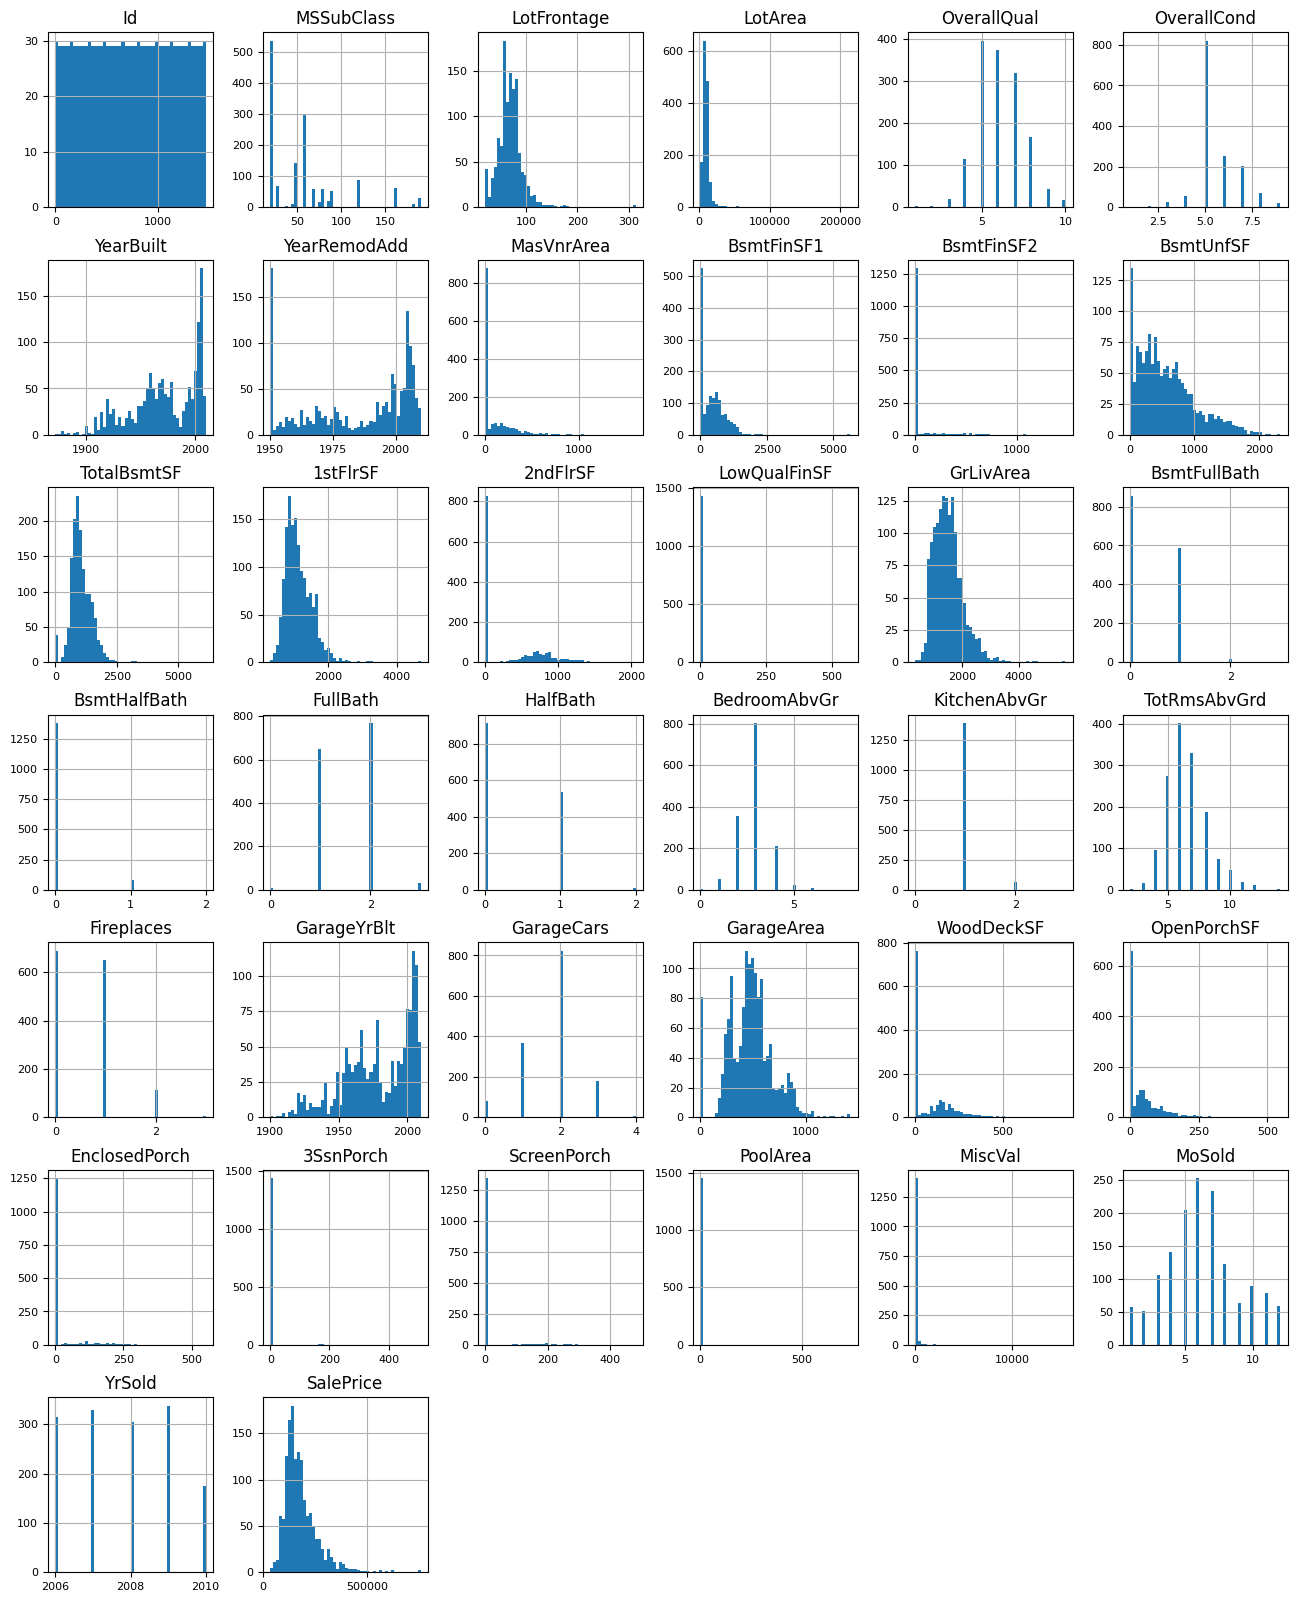

In [7]:
df_numeric.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

1.4.2 Check for correlation

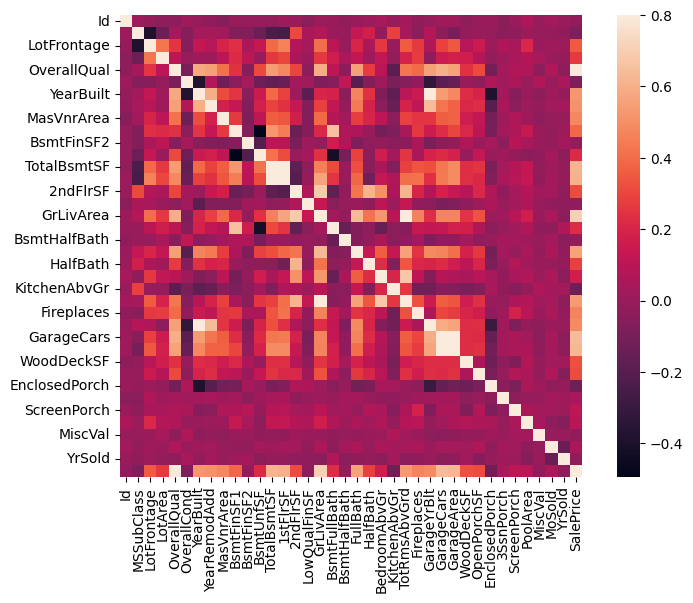

In [8]:
corrmat = df_numeric.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, vmax=.8, square=True);

In [9]:
df_num_corr = df_numeric.corr()['SalePrice'][:-1]
correlated_vars = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)

correlated_vars

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

### 1.5 Analyze Categorical Variables

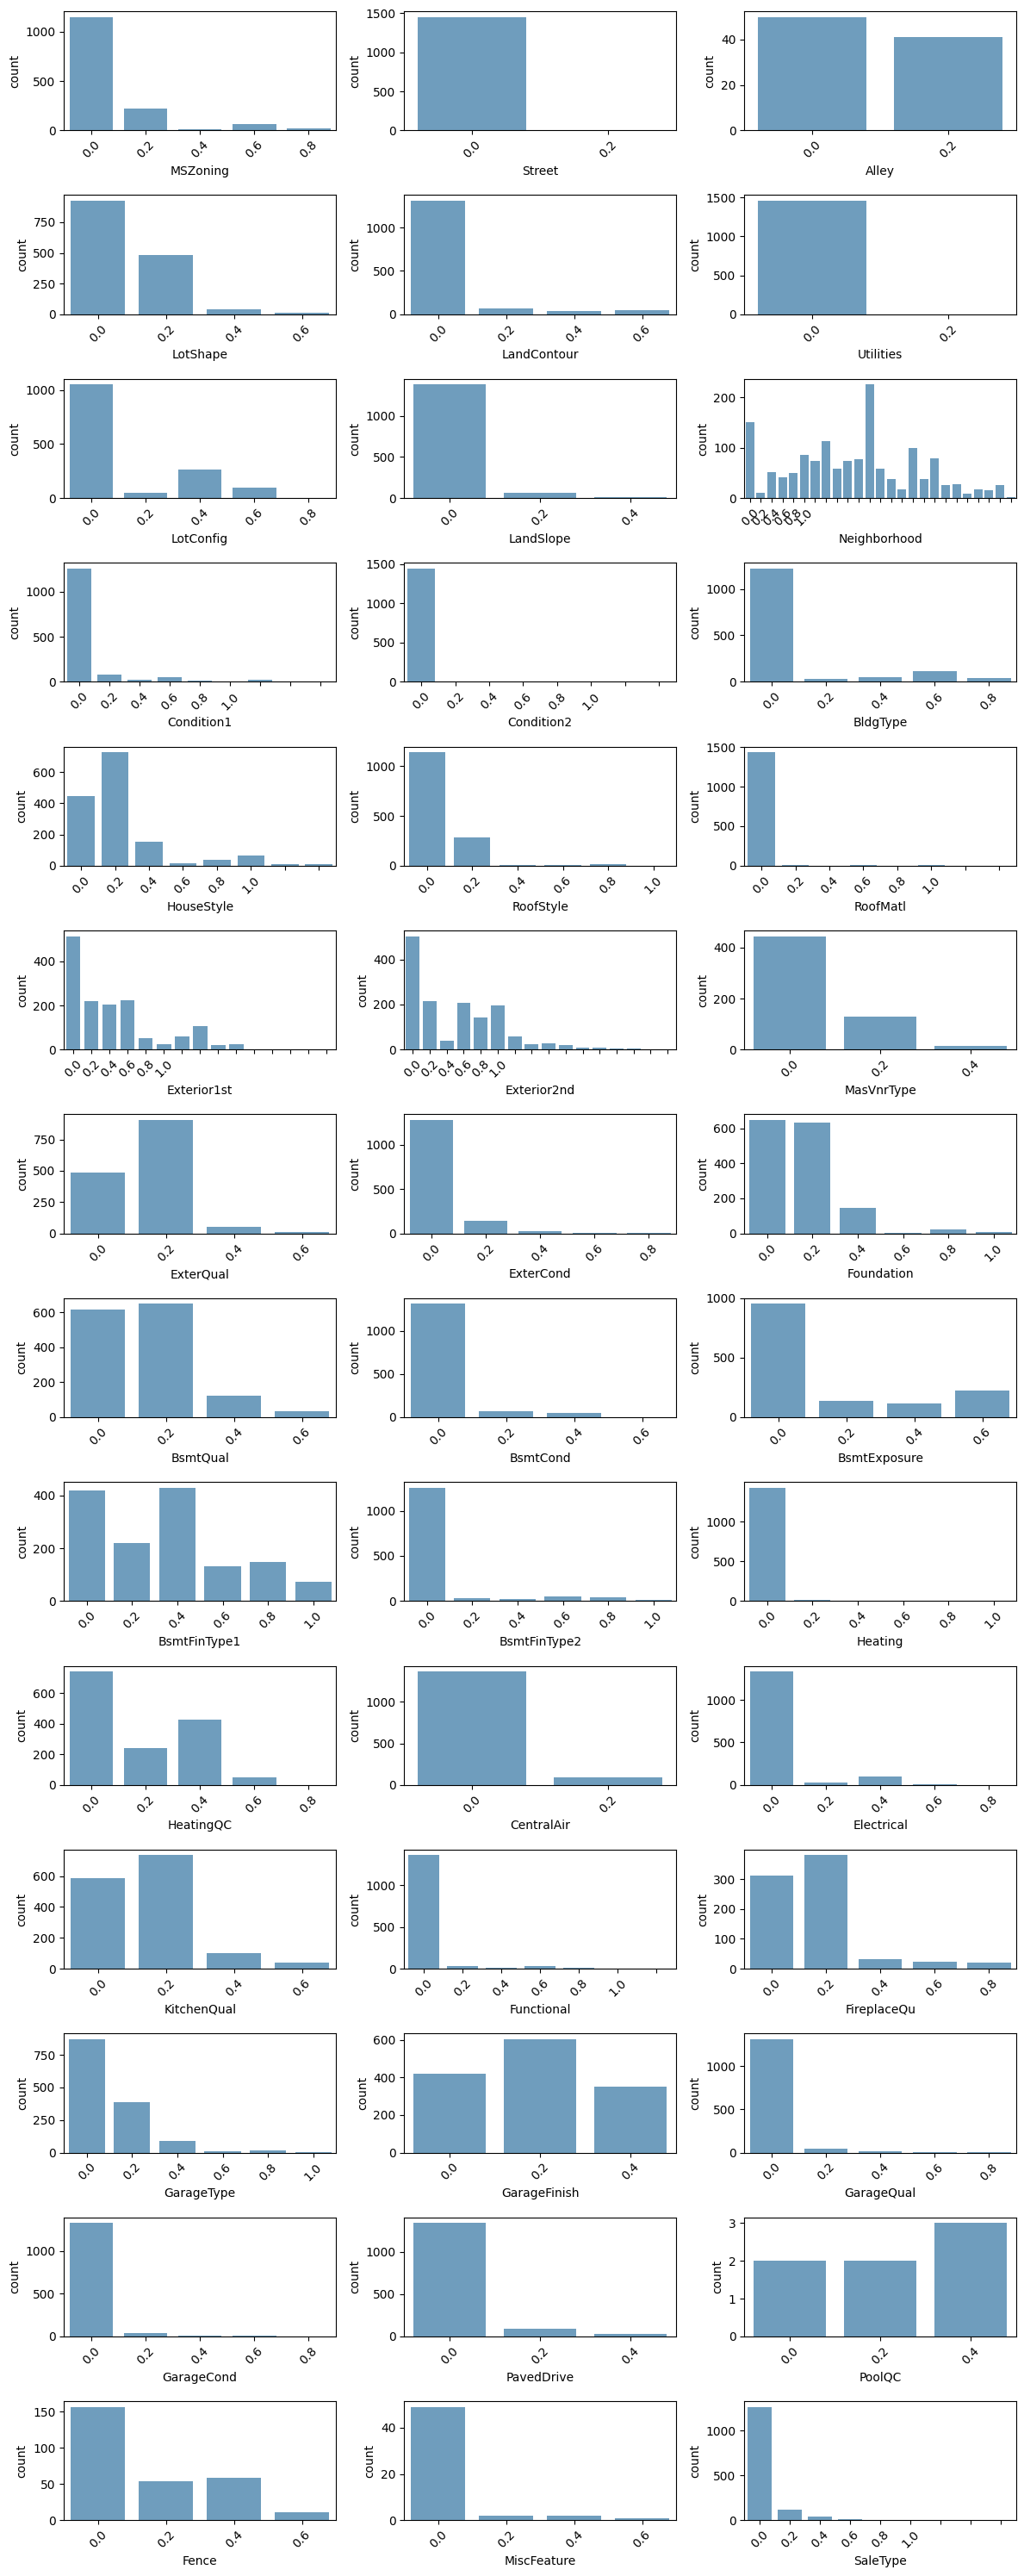

In [10]:
df_categorical = df.select_dtypes(include=['object'])
fig, axes = plt.subplots(round(len(df_categorical.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_categorical.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_categorical.columns[i], alpha=0.7, data=df_categorical, ax=ax)

fig.tight_layout()

## 2. Data Preprocessing

### 2.1 Analyze Missing values in the dataset

In [11]:
missing_vals = df.isna().sum()
missing_vals = missing_vals[missing_vals > 0]
data_types = df.dtypes[missing_vals.index]
missing_info = pd.DataFrame({
    'Missing Values': missing_vals,
    'Data Type': data_types
})
missing_info.sort_values(by='Missing Values', inplace=True)

missing_info

,Missing Values,Data Type
Electrical,1,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtFinType1,37,object
BsmtExposure,38,object
BsmtFinType2,38,object
GarageCond,81,object
GarageQual,81,object
GarageFinish,81,object


### 2.2 Define the target variables

1. For Regression Task - SalePrice

2. For Classification Task - We need to create a new variable 'House Category' from 'House Style', 'Bldg Type', 'Year Built', and 'Year Remod/Add'. 

First, we create a column to capture if the construction or latest remodeling of the property happened in the last 30 years or not, and are classified into 'Old' and 'New' properties. Next, we categorize properties by whether they are single story or multi-story by using the HouseStyle field. Then, by using the BuildingType field, they are categorized into single-family homes or multi-unit properties, including duplexes and condos.

Finally, all these 3 categorical columns created are combined to create a single HouseCategory column which will be used as the target variable for the classification task. 

This would be a multi-class classification problem since we have 8 classes of house categories created in this approach.

In [12]:
def create_cat_column(data):
    current_year = datetime.now().year

    # Determine the latest renovation done on the building (construction or remodeled date, whichever is more recent)
    data['MostRecentYear'] = data[['YearBuilt', 'YearRemodAdd']].max(axis=1)
    data['Age_Type'] = pd.cut(data['MostRecentYear'], bins=[0, current_year - 30, current_year], labels=['Old', 'New'])
    data['Age_Type'] = data['Age_Type'].astype('object')

    # Map house style into 1 story and multistory
    data['Story_Type'] = data['HouseStyle']
    data.loc[data['Story_Type']!='1Story','Story_Type'] = 'MultiStory'

    # Map the building type into single fam and multi unit (includes duplex and condo)
    data['Building_Type'] = data['BldgType']
    data.loc[data['Building_Type']!='1Fam','Building_Type'] = 'MultiUnit'

    # Combine the three new features into a single feature
    data['HouseCategory'] = data['Age_Type'] + "_" + data['Story_Type'] + "_" + data['Building_Type']

    # Drop the original features
    data.drop(['YearBuilt', 'YearRemodAdd', 'MostRecentYear', 'Age_Type', 'HouseStyle', 'Story_Type', 'BldgType', 'Building_Type'], axis=1, inplace=True)

    return data

In [13]:
df = pd.read_csv('train.csv')

In [14]:
df_new = create_cat_column(df)

### 2.3 Splitting the data into train, validation, and test sets.

Logic for splitting - Stratified split on HouseCategory - - details to be explained

In [15]:
## Stratified split on Target variable (HouseCategory)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)
for train_index, eval_index in split.split(df_new, df_new["HouseCategory"]):
    train = df.loc[train_index]
    eval = df.loc[eval_index]

train.reset_index(drop=True, inplace=True)
eval.reset_index(drop=True, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=123)
for test_index, val_index in split.split(eval, eval["HouseCategory"]):
    val = eval.loc[test_index]
    test = eval.loc[val_index]

val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### 2.4 Create a pipeline to handle all preprocessing steps

Numeric - 
Categorical - 

In [16]:
X_train = train.drop(['SalePrice','HouseCategory'], axis=1)
y_train_reg = train['SalePrice']
y_train_clas = train['HouseCategory']

X_val = val.drop(['SalePrice','HouseCategory'], axis=1)
y_val_reg = val['SalePrice']
y_val_clas = val['HouseCategory']

X_test = test.drop(['SalePrice','HouseCategory'], axis=1)
y_test_reg = test['SalePrice']
y_test_clas = test['HouseCategory']

In [17]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [18]:
# Scaler for the regression model target
reg_target_scaler = StandardScaler()

y_reg_train_scaled = reg_target_scaler.fit_transform(y_train_reg.values.reshape(-1, 1)).flatten()
y_reg_val_scaled = reg_target_scaler.transform(y_val_reg.values.reshape(-1, 1)).flatten()
y_reg_test_scaled = reg_target_scaler.transform(y_test_reg.values.reshape(-1, 1)).flatten()

In [19]:
# Label encoder for classification model target
class_label_encoder = LabelEncoder()

y_clas_train_encoded = class_label_encoder.fit_transform(y_train_clas)
y_clas_val_encoded = class_label_encoder.transform(y_val_clas)
y_clas_test_encoded = class_label_encoder.transform(y_test_clas)

### 2.5 Creating a custom dataloader

In [20]:
class MultiTaskDataModule(LightningDataModule):
    def __init__(self, X_train, y_reg_train, y_class_train, X_val, y_reg_val, y_class_val, X_test, y_reg_test, y_class_test, batch_size=32):
        super().__init__()
        self.X_train = torch.tensor(X_train.toarray(), dtype=torch.float32)
        self.y_reg_train = torch.tensor(y_reg_train, dtype=torch.float32)
        self.y_class_train = torch.tensor(y_class_train, dtype=torch.long)
        self.X_val = torch.tensor(X_val.toarray(), dtype=torch.float32)
        self.y_reg_val = torch.tensor(y_reg_val, dtype=torch.float32)
        self.y_class_val = torch.tensor(y_class_val, dtype=torch.long)
        self.X_test = torch.tensor(X_test.toarray(), dtype=torch.float32)
        self.y_reg_test = torch.tensor(y_reg_test, dtype=torch.float32)
        self.y_class_test = torch.tensor(y_class_test, dtype=torch.long)
        self.batch_size = batch_size

    def train_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.y_reg_train, self.y_class_train)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        val_dataset = TensorDataset(self.X_val, self.y_reg_val, self.y_class_val)
        return DataLoader(val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        test_dataset = TensorDataset(self.X_test, self.y_reg_test, self.y_class_test)
        return DataLoader(test_dataset, batch_size=self.batch_size)

In [21]:
data_module = MultiTaskDataModule(X_train, y_reg_train_scaled, y_clas_train_encoded, X_val, y_reg_val_scaled, y_clas_val_encoded, X_test, y_reg_test_scaled, y_clas_test_encoded)

## 3. Multi-task Model Building

### 3.1 Create a basic feed-forward neural network architecture for Multi-task learning using Pytorch Lightning

In [21]:
class MultiTaskModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim_reg, output_dim_cls):
        super(MultiTaskModel, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.regression_head = nn.Linear(hidden_dim, output_dim_reg)
        self.classification_head = nn.Linear(hidden_dim, output_dim_cls)
        
        self.loss_reg = nn.MSELoss()
        self.loss_cls = nn.CrossEntropyLoss()
        
        # Metrics
        self.train_accuracy = Accuracy(num_classes=output_dim_cls,task='multiclass')
        self.val_accuracy = Accuracy(num_classes=output_dim_cls,task='multiclass')
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()

    def forward(self, x):
        shared_out = self.shared(x)
        reg_out = self.regression_head(shared_out)
        cls_out = self.classification_head(shared_out)
        return reg_out, cls_out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        loss = loss_reg + loss_cls 
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_mse', self.train_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_acc', self.train_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        loss = loss_reg + loss_cls
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_mse', self.val_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_acc', self.val_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        return loss


In [22]:
model = MultiTaskModel(input_dim=267, hidden_dim=64, output_dim_reg=1, output_dim_cls=8)

# Initialize a trainer and fit the model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | shared              | Sequential         | 21.3 K
1 | regression_head     | Linear             | 65    
2 | classification_head | Linear             | 520   
3 | loss_reg            | MSELoss            | 0     
4 | loss_cls            | CrossEntropyLoss   | 0     
5 | train_accuracy      | MulticlassAccuracy |

Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 136.70it/s, v_num=11, val_loss=1.420, train_loss=0.00924]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 130.42it/s, v_num=11, val_loss=1.420, train_loss=0.00924]


3.1.1 Print the results of the baseline model

In [26]:
metrics = trainer.callback_metrics

train_loss = metrics.get('train_loss')
val_loss = metrics.get('val_loss')

val_mse = metrics.get('val_mse')
val_acc = metrics.get('val_acc')

print(f"Train Loss (total): {train_loss}")
print(f"Validation Loss (total): {val_loss}")

print(f"\nValidation MSE: {val_mse}")
print(f"Validation Accuracy: {val_acc}")

Train Loss (total): 0.009242911823093891
Validation Loss (total): 1.4210320711135864

Validation MSE: 0.29792946577072144
Validation Accuracy: 0.8264840245246887


### 3.2 Experimenting with different Activation Functions & Optimizers

In [32]:
class MultiTaskExperimentModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim_reg, output_dim_cls, activation_fn, optimizer_type):
        super().__init__()
        self.activation_fn = activation_fn()
        
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation_fn,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation_fn
        )
        self.regression_head = nn.Linear(hidden_dim, output_dim_reg)
        self.classification_head = nn.Linear(hidden_dim, output_dim_cls)
        
        self.loss_reg = nn.MSELoss()
        self.loss_cls = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.val_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        
        self.optimizer_type = optimizer_type

    def forward(self, x):
        shared_out = self.shared(x)
        reg_out = self.regression_head(shared_out)
        cls_out = self.classification_head(shared_out)
        return reg_out, cls_out

    def configure_optimizers(self):
        if self.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        elif self.optimizer_type == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        elif self.optimizer_type == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=0.01)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        loss = loss_reg + loss_cls
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_mse', self.train_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_acc', self.train_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        loss = loss_reg + loss_cls
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_mse', self.val_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_acc', self.val_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        return loss

In [33]:
experiments = [
    {'activation_fn': nn.ReLU, 'optimizer_type': 'Adam'},
    {'activation_fn': nn.LeakyReLU, 'optimizer_type': 'SGD'},
    {'activation_fn': nn.Tanh, 'optimizer_type': 'RMSprop'},
    {'activation_fn': nn.ReLU, 'optimizer_type': 'SGD'},
    {'activation_fn': nn.LeakyReLU, 'optimizer_type': 'Adam'},
    {'activation_fn': nn.Tanh, 'optimizer_type': 'Adam'},
    {'activation_fn': nn.ReLU, 'optimizer_type': 'RMSprop'},
    {'activation_fn': nn.LeakyReLU, 'optimizer_type': 'RMSprop'},
    {'activation_fn': nn.Tanh, 'optimizer_type': 'SGD'}
]

In [36]:
results = pd.DataFrame()

for exp in experiments:
    model = MultiTaskExperimentModel(
        input_dim=267, hidden_dim=64, output_dim_reg=1, output_dim_cls=8,
        activation_fn=exp['activation_fn'], optimizer_type=exp['optimizer_type']
    )
    trainer = pl.Trainer(max_epochs=100)
    trainer.fit(model, datamodule=data_module)

    val_loss = trainer.callback_metrics.get('val_loss')
    val_mse = trainer.callback_metrics.get('val_mse')
    val_accuracy = trainer.callback_metrics.get('val_acc')
    
    result_df = pd.DataFrame({
        'Activation Function': [exp['activation_fn'].__name__],
        'Optimizer': [exp['optimizer_type']],
        'Val Loss': [val_loss],
        'Val MSE': [val_mse],
        'Val Accuracy': [val_accuracy]
    })
    results = pd.concat([results, result_df])
    print(result_df)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | ReLU               | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 146.97it/s, v_num=22, val_loss=1.530, train_loss=0.0139] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 139.39it/s, v_num=22, val_loss=1.530, train_loss=0.0139]
  Activation Function Optimizer        Val Loss         Val MSE  \
0                ReLU      Adam  tensor(1.5282)  tensor(0.2901)   

     Val Accuracy  
0  tensor(0.8265)  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | LeakyReLU          | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     

Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 128.50it/s, v_num=23, val_loss=1.080, train_loss=0.0202]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 95.74it/s, v_num=23, val_loss=1.080, train_loss=0.0202] 

GPU available: True (cuda), used: True



  Activation Function Optimizer        Val Loss         Val MSE  \
0           LeakyReLU       SGD  tensor(1.0844)  tensor(0.3325)   

     Val Accuracy  
0  tensor(0.8584)  


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | Tanh               | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 150.49it/s, v_num=24, val_loss=1.360, train_loss=0.0476]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 110.23it/s, v_num=24, val_loss=1.360, train_loss=0.0476]

GPU available: True (cuda), used: True



  Activation Function Optimizer        Val Loss         Val MSE  \
0                Tanh   RMSprop  tensor(1.3646)  tensor(0.3098)   

     Val Accuracy  
0  tensor(0.8219)  


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | ReLU               | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 148.09it/s, v_num=25, val_loss=1.110, train_loss=0.0163]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 102.14it/s, v_num=25, val_loss=1.110, train_loss=0.0163]

GPU available: True (cuda), used: True



  Activation Function Optimizer        Val Loss         Val MSE  \
0                ReLU       SGD  tensor(1.1097)  tensor(0.2207)   

     Val Accuracy  
0  tensor(0.8447)  


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | LeakyReLU          | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 155.59it/s, v_num=26, val_loss=1.050, train_loss=0.138]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 148.98it/s, v_num=26, val_loss=1.050, train_loss=0.138]

GPU available: True (cuda), used: True



  Activation Function Optimizer        Val Loss         Val MSE  \
0           LeakyReLU      Adam  tensor(1.0511)  tensor(0.2729)   

     Val Accuracy  
0  tensor(0.8265)  


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | Tanh               | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 135.56it/s, v_num=27, val_loss=1.110, train_loss=0.0156] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 125.49it/s, v_num=27, val_loss=1.110, train_loss=0.0156]

GPU available: True (cuda), used: True



  Activation Function Optimizer        Val Loss         Val MSE  \
0                Tanh      Adam  tensor(1.1139)  tensor(0.2944)   

     Val Accuracy  
0  tensor(0.8493)  


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | ReLU               | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 163.92it/s, v_num=28, val_loss=1.680, train_loss=0.326] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 104.73it/s, v_num=28, val_loss=1.680, train_loss=0.326]
  Activation Function Optimizer        Val Loss         Val MSE  \
0                ReLU   RMSprop  tensor(1.6825)  tensor(0.2445)   

     Val Accuracy  
0  tensor(0.7763)  
Epoch 85:  31%|███▏      | 10/32 [19:17<42:25,  0.01it/s, val_loss=2.190, train_loss=0.00143] 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | LeakyReLU          | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 140.40it/s, v_num=29, val_loss=1.720, train_loss=0.0378]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 104.06it/s, v_num=29, val_loss=1.720, train_loss=0.0378]

GPU available: True (cuda), used: True



  Activation Function Optimizer        Val Loss         Val MSE  \
0           LeakyReLU   RMSprop  tensor(1.7227)  tensor(0.3546)   

     Val Accuracy  
0  tensor(0.7854)  


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | Tanh               | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 131.02it/s, v_num=30, val_loss=0.892, train_loss=0.0116]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 61.87it/s, v_num=30, val_loss=0.892, train_loss=0.0116] 
  Activation Function Optimizer        Val Loss         Val MSE  \
0                Tanh       SGD  tensor(0.8924)  tensor(0.2239)   

     Val Accuracy  
0  tensor(0.8539)  


3.2.1 Display the results of model experiments

In [39]:
results['Val Loss'] = results['Val Loss'].apply(lambda x: x.item() if torch.is_tensor(x) else x)
results['Val MSE'] = results['Val MSE'].apply(lambda x: x.item() if torch.is_tensor(x) else x)
results['Val Accuracy'] = results['Val Accuracy'].apply(lambda x: x.item() if torch.is_tensor(x) else x)

results.sort_values(by='Val Loss', inplace=True)
results    

,Activation Function,Optimizer,Val Loss,Val MSE,Val Accuracy
0,Tanh,SGD,0.892365,0.223909,0.853881
0,LeakyReLU,Adam,1.051121,0.272876,0.826484
0,LeakyReLU,SGD,1.084371,0.332503,0.858447
0,ReLU,SGD,1.109693,0.220731,0.844749
0,Tanh,Adam,1.113941,0.294431,0.849315
0,Tanh,RMSprop,1.364636,0.309836,0.821918
0,ReLU,Adam,1.528155,0.290102,0.826484
0,ReLU,RMSprop,1.682473,0.244514,0.776256
0,LeakyReLU,RMSprop,1.722731,0.354577,0.785388


### 3.3 Using Custom Loss Functions for both tasks

In [40]:
class MultiTaskModel_CustomLossFn(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim_reg, output_dim_cls, activation_fn, optimizer_type, loss_reg_weight=1.0, loss_cls_weight=1.0):
        super().__init__()
        self.activation_fn = activation_fn()
        
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation_fn,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation_fn
        )
        self.regression_head = nn.Linear(hidden_dim, output_dim_reg)
        self.classification_head = nn.Linear(hidden_dim, output_dim_cls)
        
        self.loss_reg = nn.MSELoss()
        self.loss_cls = nn.CrossEntropyLoss()
        self.loss_reg_weight = loss_reg_weight
        self.loss_cls_weight = loss_cls_weight

        # Metrics
        self.train_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.val_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        
        self.optimizer_type = optimizer_type

    def forward(self, x):
        shared_out = self.shared(x)
        reg_out = self.regression_head(shared_out)
        cls_out = self.classification_head(shared_out)
        return reg_out, cls_out

    def configure_optimizers(self):
        if self.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        elif self.optimizer_type == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        elif self.optimizer_type == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=0.01)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mse', self.train_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_acc', self.train_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('val_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_mse', self.val_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_acc', self.val_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss

3.3.1 Train the Model with Custom Loss Function

Assuming that the requirement was that predicting house prices accurately is more important than predicting the house categories, I am using the best activation function and optimizer from the previous step with this approach to train the model

In [42]:
model = MultiTaskModel_CustomLossFn(input_dim=267, hidden_dim=64, output_dim_reg=1, output_dim_cls=8,activation_fn=nn.Tanh, optimizer_type='SGD', loss_reg_weight=2.0, loss_cls_weight=1.0)

# Initialize a trainer and fit the model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | activation_fn       | Tanh               | 0     
1 | shared              | Sequential         | 21.3 K
2 | regression_head     | Linear             | 65    
3 | classification_head | Linear             | 520   
4 | loss_reg            | MSELoss            | 0     
5 | loss_cls            | CrossEntropyLoss   | 0     
6 | train_accuracy      | MulticlassAccuracy | 0     
7 | val_accuracy        | MulticlassAccuracy | 0     
8 | train_mse           | MeanSquaredError   | 0     
9 | val_mse             | MeanSquaredError   | 0     
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.088     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 106.22it/s, v_num=31, train_loss_step=0.0305, val_loss_step=1.220, val_loss_epoch=1.190, train_loss_epoch=0.0165] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 81.93it/s, v_num=31, train_loss_step=0.0305, val_loss_step=1.220, val_loss_epoch=1.190, train_loss_epoch=0.0165] 


3.3.2 Display the results with this approach

In [43]:
metrics = trainer.callback_metrics

train_loss = metrics.get('train_loss')
val_loss = metrics.get('val_loss')

val_mse = metrics.get('val_mse')
val_acc = metrics.get('val_acc')

print(f"Train Loss (total): {train_loss}")
print(f"Validation Loss (total): {val_loss}")

print(f"\nValidation MSE: {val_mse}")
print(f"Validation Accuracy: {val_acc}")

Train Loss (total): 0.01649593934416771
Validation Loss (total): 1.190544605255127

Validation MSE: 0.18980993330478668
Validation Accuracy: 0.8401826620101929


### 3.4 Add metrics for Model Evaluation

So far, for model evaluation, I have used Mean Squared Error (MSE) as the metric for the regression task, and Accuracy as the metric for the classification task. We can also use additional metrics from the "torchmetrics" module in PyTorch Lightning to log additional metrics for model evaluation. For this section, I am logging 4 additional metrics for model evaluation - R2Score and Mean Absolute Error for the regression task, and ROC-AUC score and F1 score for the classification task.

In [15]:
class MultiTaskModel_EvalMetrics(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim_reg, output_dim_cls, activation_fn, optimizer_type, loss_reg_weight=1.0, loss_cls_weight=1.0):
        super().__init__()
        self.activation_fn = activation_fn()
        
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation_fn,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation_fn
        )
        self.regression_head = nn.Linear(hidden_dim, output_dim_reg)
        self.classification_head = nn.Linear(hidden_dim, output_dim_cls)
        
        self.loss_reg = nn.MSELoss()
        self.loss_cls = nn.CrossEntropyLoss()
        self.loss_reg_weight = loss_reg_weight
        self.loss_cls_weight = loss_cls_weight

        # Metrics
        self.train_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.val_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.train_rocauc = AUROC(num_classes=output_dim_cls, task='multiclass')
        self.val_rocauc = AUROC(num_classes=output_dim_cls, task='multiclass')
        self.train_f1 = F1Score(num_classes=output_dim_cls, task='multiclass')
        self.val_f1 = F1Score(num_classes=output_dim_cls, task='multiclass')

        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.train_r2score = R2Score()
        self.val_r2score = R2Score()
        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()

        
        self.optimizer_type = optimizer_type

    def forward(self, x):
        shared_out = self.shared(x)
        reg_out = self.regression_head(shared_out)
        cls_out = self.classification_head(shared_out)
        return reg_out, cls_out

    def configure_optimizers(self):
        if self.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        elif self.optimizer_type == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        elif self.optimizer_type == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=0.01)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mse', self.train_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_r2', self.train_r2score(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_mae', self.train_mae(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_acc', self.train_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('train_rocauc', self.train_rocauc(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('train_f1', self.train_f1(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('val_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_mse', self.val_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_r2', self.val_r2score(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_mae', self.val_mae(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_acc', self.val_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('val_rocauc', self.val_rocauc(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('val_f1', self.val_f1(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss

3.4.1 Train the model with additional evaluation metrics logged

In [48]:
model = MultiTaskModel_EvalMetrics(input_dim=267, hidden_dim=64, output_dim_reg=1, output_dim_cls=8,activation_fn=nn.Tanh, optimizer_type='SGD', loss_reg_weight=1.0, loss_cls_weight=1.0)

# Initialize a trainer and fit the model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Tanh               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        | MulticlassAccuracy | 0     
8  | train_rocauc        | MulticlassAUROC    | 0     
9  | val_rocauc          | MulticlassAUROC    | 0     
10 | train_f1            | MulticlassF1Score  | 0     
11 | val_f1              | MulticlassF1Score  | 0     
12 | train_mse           | Me

Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 47.65it/s, v_num=32, train_loss_step=0.010, val_loss_step=1.110, val_loss_epoch=1.050, train_loss_epoch=0.0121]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 41.63it/s, v_num=32, train_loss_step=0.010, val_loss_step=1.110, val_loss_epoch=1.050, train_loss_epoch=0.0121]


3.4.2 Display the additional evaluation metrics logged

In [49]:
metrics = trainer.callback_metrics

train_loss = metrics.get('train_loss')
val_loss = metrics.get('val_loss')

val_mse = metrics.get('val_mse')
val_r2 = metrics.get('val_r2')
val_mae = metrics.get('val_mae')
val_acc = metrics.get('val_acc')
val_rocauc = metrics.get('val_rocauc')
val_f1 = metrics.get('val_f1')


print(f"Train Loss (total): {train_loss}")
print(f"Validation Loss (total): {val_loss}")

print(f"\nValidation MSE: {val_mse}")
print(f"Validation R2 Score: {val_r2}")
print(f"Validation MAE: {val_mae}")

print(f"\nValidation Accuracy: {val_acc}")
print(f"Validation ROC AUC: {val_rocauc}")
print(f"Validation F1 Score: {val_f1}")

Train Loss (total): 0.01213216595351696
Validation Loss (total): 1.0533454418182373

Validation MSE: 0.2670721709728241
Validation R2 Score: 0.7836796045303345
Validation MAE: 0.2737565040588379

Validation Accuracy: 0.844748854637146
Validation ROC AUC: 0.8608550429344177
Validation F1 Score: 0.844748854637146


### 3.5 Advanced PyTorch Lightning Features

Include logging, callback system, and Trainer API

In [16]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./models/',
    filename='best-model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    strict=True,
    verbose=True,
    mode='min'
)

model = MultiTaskModel_EvalMetrics(input_dim=267, hidden_dim=64, output_dim_reg=1, output_dim_cls=8,activation_fn=nn.Tanh, optimizer_type='SGD', loss_reg_weight=1.0, loss_cls_weight=1.0)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping],
    max_epochs=100
)
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Tanh               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropy

Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 45.77it/s, v_num=35, train_loss_step=1.910, val_loss_step=1.550, val_loss_epoch=1.900, train_loss_epoch=2.280]

Metric val_loss improved. New best score: 1.903


Epoch 1: 100%|██████████| 32/32 [00:00<00:00, 45.60it/s, v_num=35, train_loss_step=1.540, val_loss_step=1.120, val_loss_epoch=1.460, train_loss_epoch=1.590]

Metric val_loss improved by 0.448 >= min_delta = 0.0. New best score: 1.455


Epoch 2: 100%|██████████| 32/32 [00:00<00:00, 49.07it/s, v_num=35, train_loss_step=1.050, val_loss_step=0.775, val_loss_epoch=1.080, train_loss_epoch=1.140]

Metric val_loss improved by 0.378 >= min_delta = 0.0. New best score: 1.077


Epoch 3: 100%|██████████| 32/32 [00:00<00:00, 49.77it/s, v_num=35, train_loss_step=0.707, val_loss_step=0.619, val_loss_epoch=0.886, train_loss_epoch=0.835]

Metric val_loss improved by 0.192 >= min_delta = 0.0. New best score: 0.886


Epoch 4: 100%|██████████| 32/32 [00:00<00:00, 45.42it/s, v_num=35, train_loss_step=0.487, val_loss_step=0.582, val_loss_epoch=0.805, train_loss_epoch=0.682]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 0.805


Epoch 5: 100%|██████████| 32/32 [00:00<00:00, 51.38it/s, v_num=35, train_loss_step=0.410, val_loss_step=0.535, val_loss_epoch=0.740, train_loss_epoch=0.594]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.740


Epoch 6: 100%|██████████| 32/32 [00:00<00:00, 41.87it/s, v_num=35, train_loss_step=0.439, val_loss_step=0.520, val_loss_epoch=0.719, train_loss_epoch=0.533]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.719


Epoch 8: 100%|██████████| 32/32 [00:00<00:00, 49.67it/s, v_num=35, train_loss_step=0.512, val_loss_step=0.512, val_loss_epoch=0.702, train_loss_epoch=0.470]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.702


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 43.96it/s, v_num=35, train_loss_step=0.588, val_loss_step=0.488, val_loss_epoch=0.685, train_loss_epoch=0.436]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.685


Epoch 21: 100%|██████████| 32/32 [00:00<00:00, 48.95it/s, v_num=35, train_loss_step=0.267, val_loss_step=0.566, val_loss_epoch=0.681, train_loss_epoch=0.255]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.681


Epoch 41: 100%|██████████| 32/32 [00:02<00:00, 11.57it/s, v_num=35, train_loss_step=0.078, val_loss_step=0.871, val_loss_epoch=0.827, train_loss_epoch=0.0965]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.681. Signaling Trainer to stop.


Epoch 41: 100%|██████████| 32/32 [00:02<00:00, 11.43it/s, v_num=35, train_loss_step=0.078, val_loss_step=0.871, val_loss_epoch=0.827, train_loss_epoch=0.0965]


### 3.6 Hyperparameter Tuning using Optuna

In [23]:
class MultiTaskModel_HPO(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim_reg, output_dim_cls, activation_fn, optimizer_type, lr=0.01, loss_reg_weight=1.0, loss_cls_weight=1.0):
        super().__init__()
        self.activation_fn = activation_fn()
        
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation_fn,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation_fn
        )
        self.regression_head = nn.Linear(hidden_dim, output_dim_reg)
        self.classification_head = nn.Linear(hidden_dim, output_dim_cls)
        
        self.loss_reg = nn.MSELoss()
        self.loss_cls = nn.CrossEntropyLoss()
        self.loss_reg_weight = loss_reg_weight
        self.loss_cls_weight = loss_cls_weight
        self.lr = lr

        # Metrics
        self.train_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.val_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.train_rocauc = AUROC(num_classes=output_dim_cls, task='multiclass')
        self.val_rocauc = AUROC(num_classes=output_dim_cls, task='multiclass')
        self.train_f1 = F1Score(num_classes=output_dim_cls, task='multiclass')
        self.val_f1 = F1Score(num_classes=output_dim_cls, task='multiclass')

        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.train_r2score = R2Score()
        self.val_r2score = R2Score()
        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()

        
        self.optimizer_type = optimizer_type

    def forward(self, x):
        shared_out = self.shared(x)
        reg_out = self.regression_head(shared_out)
        cls_out = self.classification_head(shared_out)
        return reg_out, cls_out

    def configure_optimizers(self):
        if self.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.optimizer_type == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        elif self.optimizer_type == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mse', self.train_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_r2', self.train_r2score(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_mae', self.train_mae(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_acc', self.train_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('train_rocauc', self.train_rocauc(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('train_f1', self.train_f1(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('val_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_mse', self.val_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_r2', self.val_r2score(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_mae', self.val_mae(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_acc', self.val_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('val_rocauc', self.val_rocauc(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('val_f1', self.val_f1(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss

In [21]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    optimizer_type = trial.suggest_categorical('optimizer_type', ['Adam', 'SGD', 'RMSprop'])
    activation_fn = trial.suggest_categorical('activation_fn', [nn.ReLU, nn.LeakyReLU, nn.Tanh, nn.Sigmoid])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    model = MultiTaskModel_HPO(
        input_dim=267,
        hidden_dim=64,
        output_dim_reg=1,
        output_dim_cls=8,
        activation_fn=activation_fn,
        optimizer_type=optimizer_type,
        lr=lr,
        loss_reg_weight=1.0, 
        loss_cls_weight=1.0
    )

    data_module.batch_size = batch_size

    logger = CSVLogger("logs", name="multi-task-optuna")

    early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=10, verbose=False, mode='min')
    
    trainer = Trainer(
        logger=logger,
        callbacks=[early_stop_callback],
        max_epochs=100
    )

    trainer.fit(model, datamodule=data_module)

    val_loss = trainer.callback_metrics['val_loss'].item()
    return val_loss

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2024-04-28 21:27:12,095] A new study created in memory with name: no-name-f6a034d4-8c2d-4dbd-981f-9ce25d3c492e
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\multi-task-optuna
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | LeakyReLU          | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        | MulticlassAccuracy | 0     
8  | train_rocauc        | MulticlassAUROC    | 0     
9  | val_rocauc          | Multicl

Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 49.18it/s, v_num=0, train_loss_step=0.403, val_loss_step=0.504, val_loss_epoch=0.772, train_loss_epoch=0.424]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 45.14it/s, v_num=0, train_loss_step=0.403, val_loss_step=0.504, val_loss_epoch=0.772, train_loss_epoch=0.424]


[I 2024-04-28 21:28:43,337] Trial 0 finished with value: 0.7723724246025085 and parameters: {'lr': 0.006424341602899503, 'optimizer_type': 'SGD', 'activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'batch_size': 32}. Best is trial 0 with value: 0.7723724246025085.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Sigmoid            | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        

Epoch 99: 100%|██████████| 64/64 [00:01<00:00, 46.09it/s, v_num=1, train_loss_step=1.500, val_loss_step=1.710, val_loss_epoch=1.910, train_loss_epoch=1.780]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 64/64 [00:01<00:00, 43.39it/s, v_num=1, train_loss_step=1.500, val_loss_step=1.710, val_loss_epoch=1.910, train_loss_epoch=1.780]


[I 2024-04-28 21:34:14,861] Trial 1 finished with value: 1.9080114364624023 and parameters: {'lr': 0.0050586504582535614, 'optimizer_type': 'SGD', 'activation_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'batch_size': 16}. Best is trial 0 with value: 0.7723724246025085.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Tanh               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        |

Epoch 76: 100%|██████████| 8/8 [00:00<00:00, 10.52it/s, v_num=2, train_loss_step=0.362, val_loss_step=0.494, val_loss_epoch=0.728, train_loss_epoch=0.337]


[I 2024-04-28 21:35:22,090] Trial 2 finished with value: 0.7282933592796326 and parameters: {'lr': 0.06566815520772001, 'optimizer_type': 'SGD', 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'batch_size': 128}. Best is trial 2 with value: 0.7282933592796326.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Tanh               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        | Mul

Epoch 15: 100%|██████████| 32/32 [00:02<00:00, 12.99it/s, v_num=3, train_loss_step=0.192, val_loss_step=0.835, val_loss_epoch=0.821, train_loss_epoch=0.191] 


[I 2024-04-28 21:36:04,023] Trial 3 finished with value: 0.821166455745697 and parameters: {'lr': 0.0018160958779765116, 'optimizer_type': 'Adam', 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'batch_size': 32}. Best is trial 2 with value: 0.7282933592796326.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | ReLU               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        | Mu

Epoch 17: 100%|██████████| 32/32 [00:03<00:00, 10.40it/s, v_num=4, train_loss_step=0.130, val_loss_step=0.660, val_loss_epoch=0.900, train_loss_epoch=0.175] 


[I 2024-04-28 21:36:54,244] Trial 4 finished with value: 0.9001701474189758 and parameters: {'lr': 0.0012454168007286672, 'optimizer_type': 'RMSprop', 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 32}. Best is trial 2 with value: 0.7282933592796326.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Tanh               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        

Epoch 12: 100%|██████████| 64/64 [00:04<00:00, 13.65it/s, v_num=5, train_loss_step=0.180, val_loss_step=0.419, val_loss_epoch=0.788, train_loss_epoch=0.184] 


[I 2024-04-28 21:37:28,175] Trial 5 finished with value: 0.7877601981163025 and parameters: {'lr': 0.0019491406723285123, 'optimizer_type': 'RMSprop', 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'batch_size': 16}. Best is trial 2 with value: 0.7282933592796326.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Tanh               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        

Epoch 21: 100%|██████████| 32/32 [00:02<00:00, 14.53it/s, v_num=6, train_loss_step=0.480, val_loss_step=0.735, val_loss_epoch=0.733, train_loss_epoch=0.222] 


[I 2024-04-28 21:38:29,795] Trial 6 finished with value: 0.7325117588043213 and parameters: {'lr': 0.0008703482456645196, 'optimizer_type': 'Adam', 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'batch_size': 32}. Best is trial 2 with value: 0.7282933592796326.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | ReLU               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        | M

Epoch 51: 100%|██████████| 8/8 [00:00<00:00, 10.66it/s, v_num=7, train_loss_step=0.249, val_loss_step=0.482, val_loss_epoch=0.787, train_loss_epoch=0.228]


[I 2024-04-28 21:39:13,451] Trial 7 finished with value: 0.7866554260253906 and parameters: {'lr': 0.0006978029429381314, 'optimizer_type': 'Adam', 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 128}. Best is trial 2 with value: 0.7282933592796326.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Sigmoid            | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        | 

Epoch 99: 100%|██████████| 64/64 [00:01<00:00, 46.87it/s, v_num=8, train_loss_step=1.840, val_loss_step=1.720, val_loss_epoch=1.930, train_loss_epoch=1.800]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 64/64 [00:01<00:00, 45.29it/s, v_num=8, train_loss_step=1.840, val_loss_step=1.720, val_loss_epoch=1.930, train_loss_epoch=1.800]


[I 2024-04-28 21:46:09,320] Trial 8 finished with value: 1.926032304763794 and parameters: {'lr': 0.004597051091087028, 'optimizer_type': 'SGD', 'activation_fn': <class 'torch.nn.modules.activation.Sigmoid'>, 'batch_size': 16}. Best is trial 2 with value: 0.7282933592796326.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | ReLU               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        | M

Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 43.70it/s, v_num=9, train_loss_step=0.658, val_loss_step=0.677, val_loss_epoch=1.030, train_loss_epoch=0.768]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 41.73it/s, v_num=9, train_loss_step=0.658, val_loss_step=0.677, val_loss_epoch=1.030, train_loss_epoch=0.768]


[I 2024-04-28 21:47:39,625] Trial 9 finished with value: 1.0309412479400635 and parameters: {'lr': 3.7714846473033145e-05, 'optimizer_type': 'Adam', 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 32}. Best is trial 2 with value: 0.7282933592796326.


Best trial:
Value: 0.7282933592796326
Params: 
lr: 0.06566815520772001
optimizer_type: SGD
activation_fn: <class 'torch.nn.modules.activation.Tanh'>
batch_size: 128


3.6.1 Print the best hyperparameters found by Optuna

In [24]:
print("Best trial:")
trial = study.best_trial
print(f"Validation Loss: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Best trial:
Validation Loss: 0.7282933592796326
Params: 
lr: 0.06566815520772001
optimizer_type: SGD
activation_fn: <class 'torch.nn.modules.activation.Tanh'>
batch_size: 128


3.6.2 Calculate the Evaluation Metrics for the best model configuration

In [24]:
model_best = MultiTaskModel_HPO(
        input_dim=267,
        hidden_dim=64,
        output_dim_reg=1,
        output_dim_cls=8,
        activation_fn=nn.Tanh,
        optimizer_type='SGD',
        lr=0.06566815520772001,
        loss_reg_weight=1.0, 
        loss_cls_weight=1.0
    )

data_module.batch_size = 128

early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=10, verbose=False, mode='min')

trainer = Trainer(
    callbacks=[early_stop_callback],
    max_epochs=100
)

trainer.fit(model_best, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Tanh               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropy

Epoch 74: 100%|██████████| 8/8 [00:00<00:00, 32.14it/s, v_num=38, train_loss_step=0.360, val_loss_step=0.515, val_loss_epoch=0.704, train_loss_epoch=0.369] 


In [25]:
metrics = trainer.callback_metrics

train_loss = metrics.get('train_loss')
val_loss = metrics.get('val_loss')

val_mse = metrics.get('val_mse')
val_r2 = metrics.get('val_r2')
val_mae = metrics.get('val_mae')
val_acc = metrics.get('val_acc')
val_rocauc = metrics.get('val_rocauc')
val_f1 = metrics.get('val_f1')


print(f"Train Loss (total): {train_loss}")
print(f"Validation Loss (total): {val_loss}")

print(f"\nValidation MSE: {val_mse}")
print(f"Validation R2 Score: {val_r2}")
print(f"Validation MAE: {val_mae}")

print(f"\nValidation Accuracy: {val_acc}")
print(f"Validation ROC AUC: {val_rocauc}")
print(f"Validation F1 Score: {val_f1}")

Train Loss (total): 0.36887213587760925
Validation Loss (total): 0.7035284638404846

Validation MSE: 0.2569942772388458
Validation R2 Score: 0.7750805616378784
Validation MAE: 0.2769166827201843

Validation Accuracy: 0.8401826620101929
Validation ROC AUC: 0.9794339537620544
Validation F1 Score: 0.8401826620101929


## 4. Final Model Evaluation on Unseen Data (test set)

### 4.1 Define the model with test step

In [44]:
class MultiTaskModel_WithTest(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim_reg, output_dim_cls, activation_fn, optimizer_type, lr=0.01, loss_reg_weight=1.0, loss_cls_weight=1.0):
        super().__init__()
        self.activation_fn = activation_fn()
        
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation_fn,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation_fn
        )
        self.regression_head = nn.Linear(hidden_dim, output_dim_reg)
        self.classification_head = nn.Linear(hidden_dim, output_dim_cls)
        
        self.loss_reg = nn.MSELoss()
        self.loss_cls = nn.CrossEntropyLoss()
        self.loss_reg_weight = loss_reg_weight
        self.loss_cls_weight = loss_cls_weight
        self.lr = lr

        # Metrics
        self.train_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.val_accuracy = Accuracy(num_classes=output_dim_cls, task='multiclass')
        self.train_rocauc = AUROC(num_classes=output_dim_cls, task='multiclass')
        self.val_rocauc = AUROC(num_classes=output_dim_cls, task='multiclass')
        self.train_f1 = F1Score(num_classes=output_dim_cls, task='multiclass')
        self.val_f1 = F1Score(num_classes=output_dim_cls, task='multiclass')

        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.train_r2score = R2Score()
        self.val_r2score = R2Score()
        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()

        
        self.optimizer_type = optimizer_type

    def forward(self, x):
        shared_out = self.shared(x)
        reg_out = self.regression_head(shared_out)
        cls_out = self.classification_head(shared_out)
        return reg_out, cls_out

    def configure_optimizers(self):
        if self.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.optimizer_type == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        elif self.optimizer_type == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mse', self.train_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_r2', self.train_r2score(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_mae', self.train_mae(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('train_acc', self.train_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('train_rocauc', self.train_rocauc(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('train_f1', self.train_f1(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('val_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_mse', self.val_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_r2', self.val_r2score(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_mae', self.val_mae(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('val_acc', self.val_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('val_rocauc', self.val_rocauc(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('val_f1', self.val_f1(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss
    
    def test_step(self, batch, batch_idx):
        x, y_reg, y_cls = batch
        reg_pred, cls_pred = self(x)
        reg_pred = reg_pred.squeeze()
        cls_probs = torch.softmax(cls_pred, dim=1)
        cls_labels = torch.argmax(cls_probs, dim=1)
        loss_reg = self.loss_reg(reg_pred, y_reg)
        loss_cls = self.loss_cls(cls_pred, y_cls)
        total_loss = self.loss_reg_weight * loss_reg + self.loss_cls_weight * loss_cls
        self.log('test_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_mse', self.val_mse(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('test_r2', self.val_r2score(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('test_mae', self.val_mae(reg_pred, y_reg), on_step=False, on_epoch=True)
        self.log('test_acc', self.val_accuracy(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('test_rocauc', self.val_rocauc(cls_pred, y_cls), on_step=False, on_epoch=True)
        self.log('test_f1', self.val_f1(cls_pred, y_cls), on_step=False, on_epoch=True)
        return total_loss

In [45]:
model_best = MultiTaskModel_WithTest(
        input_dim=267,
        hidden_dim=64,
        output_dim_reg=1,
        output_dim_cls=8,
        activation_fn=nn.Tanh,
        optimizer_type='SGD',
        lr=0.06566815520772001,
        loss_reg_weight=1.0, 
        loss_cls_weight=1.0
    )

data_module.batch_size = 128

checkpoint_callback = ModelCheckpoint(
    dirpath='my_model_checkpoints',
    filename='best_model',
    save_top_k=1,
    monitor='val_loss',
    mode='min'
)

early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=10, verbose=False, mode='min')

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    max_epochs=100
)

trainer.fit(model_best, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



   | Name                | Type               | Params
------------------------------------------------------------
0  | activation_fn       | Tanh               | 0     
1  | shared              | Sequential         | 21.3 K
2  | regression_head     | Linear             | 65    
3  | classification_head | Linear             | 520   
4  | loss_reg            | MSELoss            | 0     
5  | loss_cls            | CrossEntropyLoss   | 0     
6  | train_accuracy      | MulticlassAccuracy | 0     
7  | val_accuracy        | MulticlassAccuracy | 0     
8  | train_rocauc        | MulticlassAUROC    | 0     
9  | val_rocauc          | MulticlassAUROC    | 0     
10 | train_f1            | MulticlassF1Score  | 0     
11 | val_f1              | MulticlassF1Score  | 0     
12 | train_mse           | MeanSquaredError   | 0     
13 | val_mse             | MeanSquaredError   | 0     
14 | train_r2score       | R2Score            | 0     
15 | val_r2score         | R2Score            | 0     
16 

Epoch 67: 100%|██████████| 8/8 [00:00<00:00, 30.56it/s, v_num=49, train_loss_step=0.316, val_loss_step=0.487, val_loss_epoch=0.704, train_loss_epoch=0.358] 


### 4.2 Make Predictions with the best model on the test set

In [42]:
results = trainer.test(model_best, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 23.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7853881120681763     │
│          test_f1          │    0.7853881120681763     │
│      test_loss_epoch      │    0.7900822758674622     │
│         test_mae          │     0.281276136636734     │
│         test_mse          │    0.22605770826339722    │
│          test_r2          │    0.8282162547111511     │
│        test_rocauc        │    0.9729886651039124     │
└───────────────────────────┴───────────────────────────┘

## 5. Save the best model and model state

In [46]:
torch.save(model_best, 'best_model_trained.pth')

torch.save(model_best.state_dict(), 'best_model_weights.pth')